
This is the lstm model for forecasting kospi volatility

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import data_reader as dr


In [151]:
data= dr.read()

In [152]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2321 entries, 22 to 2483
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 2321 non-null   object 
 1   Daily_trading_range  2321 non-null   float64
 2   Log_Volume_change    2321 non-null   float64
 3   Daily_return         2321 non-null   float64
 4   Daily_log_return     2321 non-null   float64
 5   Past_vol22           2321 non-null   float64
 6   gold                 2321 non-null   float64
 7   oil                  2321 non-null   float64
 8   Target22             2300 non-null   float64
 9   Target10             2312 non-null   float64
dtypes: float64(9), object(1)
memory usage: 199.5+ KB


In [153]:
data = data.drop(['Daily_return','Past_vol22', 'Log_Volume_change'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2321 entries, 22 to 2483
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 2321 non-null   object 
 1   Daily_trading_range  2321 non-null   float64
 2   Daily_log_return     2321 non-null   float64
 3   gold                 2321 non-null   float64
 4   oil                  2321 non-null   float64
 5   Target22             2300 non-null   float64
 6   Target10             2312 non-null   float64
dtypes: float64(6), object(1)
memory usage: 145.1+ KB


In [154]:
x_values = data.iloc[22:, 1:-2]
y_values = data[['Target22']]
y_values = y_values.iloc[22:]

In [155]:
x_values.info()
y_values.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2299 entries, 44 to 2483
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Daily_trading_range  2299 non-null   float64
 1   Daily_log_return     2299 non-null   float64
 2   gold                 2299 non-null   float64
 3   oil                  2299 non-null   float64
dtypes: float64(4)
memory usage: 89.8 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2299 entries, 44 to 2483
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Target22  2299 non-null   float64
dtypes: float64(1)
memory usage: 35.9 KB


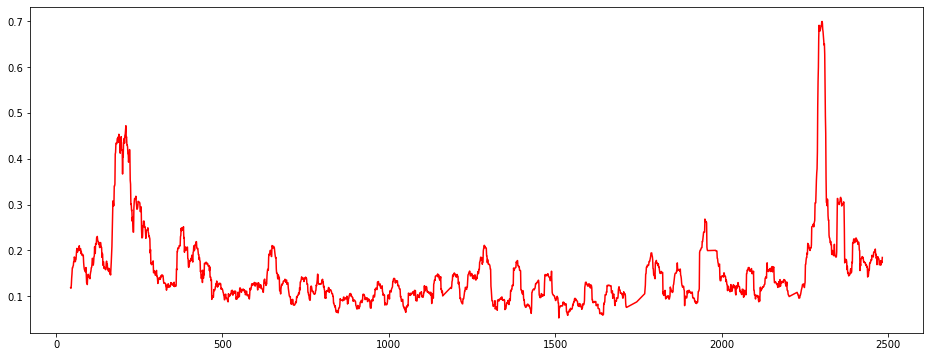

In [156]:
plt.figure(1, figsize=(16,6))
plt.plot(y_values, color='red')

In [157]:
scaler = MinMaxScaler()
scaled_x = scaler.fit_transform(x_values)
scaled_y = scaler.fit_transform(y_values)

In [158]:

y_values

,Target22
44,0.118105
45,0.117141
46,0.123905
47,0.138926
48,0.148521
...,...
2479,0.167926
2480,0.176696
2481,0.175393
2482,0.173015


In [159]:
split = int(len(x_values)*0.8)

In [160]:
window = 22
trainX = np.array(scaled_x[:split])
testX = np.array(scaled_x[split:])
trainY = np.array(scaled_y[:split])
testY = np.array(scaled_y[split:])

trainX.shape

(1839, 4)

In [161]:
Xtrain = []
ytrain = []
Xtest = []
ytest = []

for i in range(window, len(trainX)):
    Xtrain.append(trainX[i-window:i, :trainX.shape[1]])
    ytrain.append(trainY[i])
for i in range(window, len(testX)):
    Xtest.append(testX[i-window:i, :testX.shape[1]])
    ytest.append(testY[i])

In [162]:
Xtrain, ytrain = (np.array(Xtrain), np.array(ytrain))
Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], Xtrain.shape[1], Xtrain.shape[2]))

Xtest, ytest = (np.array(Xtest), np.array(ytest))
Xtest = np.reshape(Xtest, (Xtest.shape[0], Xtest.shape[1], Xtest.shape[2]))

In [163]:

print(Xtrain.shape)
print(ytrain.shape)
print("-----")
print(Xtest.shape)
print(ytest.shape)

(1817, 22, 4)
(1817, 1)
-----
(438, 22, 4)
(438, 1)


In [164]:
print(trainX)

[[0.11634641 0.54262355 0.30128911 0.84567169]
 [0.11425435 0.48106787 0.29729191 0.83570862]
 [0.19185535 0.4462707  0.29659233 0.82548168]
 ...
 [0.06714407 0.59311563 0.17167976 0.68494326]
 [0.07787577 0.48092832 0.16138704 0.67920294]
 [0.1600445  0.62848123 0.18507041 0.66851412]]


In [165]:
print(trainY)

[[0.10172506]
 [0.1002362 ]
 [0.11068288]
 ...
 [0.18032883]
 [0.18181959]
 [0.13152805]]


In [166]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error
from tensorflow import keras

In [185]:
model = Sequential()
model.add(LSTM(units=10, return_sequences=True, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(units=4, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(units=2, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(5))
model.add(Dense(1))

opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mean_absolute_error', optimizer=opt)
model.fit(Xtrain, ytrain, batch_size=16, epochs=100, validation_split=0.2, shuffle=False)

Epoch 1/150
91/91 [==============================] - 9s 37ms/step - loss: 0.1803 - val_loss: 0.0576

In [186]:
# previous_model = keras.models.load_model('models/multi_layer_lstm_model')

In [187]:
forecast = model.predict(Xtest)

In [188]:
rev_forecast = scaler.inverse_transform(forecast)
rev_ytest = scaler.inverse_transform(ytest)

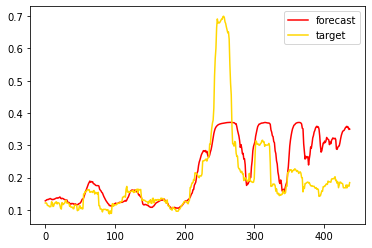

In [189]:
plt.plot(rev_forecast, color='red', label='forecast')
plt.plot(rev_ytest, color='gold', label='target')
plt.legend()
# plt.savefig("images/single_layer_model_pred.png")

plt.show()

In [190]:
testScore = mean_squared_error(rev_ytest, rev_forecast)
print("test Score: {score} MSE".format(score=testScore))
root_testScore = mean_squared_error(rev_ytest, rev_forecast, squared=False)
print("test Score: {score} RMSE".format(score=root_testScore))
mape = mean_absolute_percentage_error(rev_ytest, rev_forecast)
print("test Score: {score} MAPE".format(score=mape))

test Score: 0.0099290109781855 MSE
test Score: 0.0996444227148991 RMSE
test Score: 0.2944333361913193 MAPE


In [275]:
# model.save("models/single_layer_lstm_model")

INFO:tensorflow:Assets written to: models/single_layer_lstm_model/assets


INFO:tensorflow:Assets written to: models/single_layer_lstm_model/assets


## Experiment settings

Dataset: KOSPI index from Jan, 2011 to Dec, 2020\
Included data in default: Daily log return, Daily trading range, Log volume change\
Additional data for hybrid: Next prediction by GARCH and GJR-GARCH

- Loss function: mean_squared_error
- Optimizer: Adam
- epochs: 20
- batch_size: 16

## Experiment results


- Single-layer lstm model (32 units)
    * Training error: 0.0042, Validation error: 0.0031
    * MSE: 0.0032
    * RMSE: 0.0568
    * MAPE 0.1912

![title](images/single_layer_model_pred.png)

- Multi-layer lstm model (32 units, dropout 0.3, 32 units)
    * Training error: 0.0045, Validation error: 0.0024
    * MSE: 0.0023
    * RMSE 0.0484
    * MAPE: 0.1701
    
![title](images/multi_layer_model_pred.png)

- Single-layer hybrid model (32 units)
    * Training error: 0.0016, Validation error: 0.0001
    * MSE: 0.0007
    * RMSE: 0.0269
    * MAPE: 0.0924

![title](images/single_layer_hybrid_pred.png)

- Multi-layer hybrid model (32 units, dropout 0.3, 32 units)
    * Training error: 0.0024, Validation error: 0.0001
    * MSE: 0.0008
    * RMSE: 0.0274
    * MAPE: 0.0935
    
![title](images/multi_layer_hybrid_pred.png)